In [322]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn, optim
import torch.nn.init as init
import math


import matplotlib.pyplot as plt

In [323]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [324]:
# building_id
#columns = X.columns
data_train = pd.read_csv('./dataset-0510/train.csv')
X_test = pd.read_csv('./dataset-0510/test.csv')

In [325]:
data = data_train.append(X_test, ignore_index=True, sort=False)
data = data.drop(['building_id'], axis=1)
print(data.isnull().values.any())

True


In [326]:
# fill the nan values
data.fillna(data.median(), inplace=True)

sale_price = data['total_price'].values
data = data.drop('total_price', axis=1)

columns = data.columns
# check has any nan value in data
data.isnull().values.any()
print(type(data))
#sale_price = pd.DataFrame(sale_price, columns=['total_price'])


<class 'pandas.core.frame.DataFrame'>


In [327]:

x_scaler = MinMaxScaler()
y_scaler = StandardScaler()

scaling_data = x_scaler.fit_transform(data)
scaling_sale_price = y_scaler.fit_transform(sale_price.reshape(-1, 1))

data = pd.DataFrame(scaling_data, columns = columns)
sale_price = pd.DataFrame(scaling_sale_price, columns=['total_price'])
print(sale_price)


       total_price
0        -0.218563
1        -0.166338
2        -0.044276
3         0.046433
4        -0.216315
5        -0.223469
6        -0.064991
7        -0.198430
8        -0.211934
9        -0.000436
10       -0.081933
11       -0.011663
12       -0.168146
13       -0.137322
14       -0.084860
15       -0.025807
16       -0.175608
17       -0.150328
18       -0.103845
19       -0.112993
20        0.034442
21       -0.126267
22       -0.128854
23       -0.142278
24       -0.176988
25       -0.121903
26        0.803788
27       -0.209851
28       -0.173925
29       -0.112993
...            ...
69970    -0.128856
69971    -0.128856
69972    -0.128856
69973    -0.128856
69974    -0.128856
69975    -0.128856
69976    -0.128856
69977    -0.128856
69978    -0.128856
69979    -0.128856
69980    -0.128856
69981    -0.128856
69982    -0.128856
69983    -0.128856
69984    -0.128856
69985    -0.128856
69986    -0.128856
69987    -0.128856
69988    -0.128856
69989    -0.128856
69990    -0.

/home/islab/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [328]:
# split data
train_x = data.iloc[:60000]
test_x  = data.iloc[60000:]

train_y = sale_price.iloc[:60000]
test_y = sale_price.iloc[60000:]


In [329]:
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.33, random_state=42)

In [330]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(233, 256)
        self.norm1 = nn.BatchNorm1d(256, momentum=0.5)
        self.fc2 = nn.Linear(256, 512)
        self.norm2 = nn.BatchNorm1d(512, momentum=0.5)
        self.fc3 = nn.Linear(512, 512)
        self.norm3 = nn.BatchNorm1d(512, momentum=0.5)
        self.fc4 = nn.Linear(512, 256)
        self.norm4 = nn.BatchNorm1d(256, momentum=0.5)
        self.fc5 = nn.Linear(256, 1)
        
        
        self.dropout = nn.Dropout(p=0.5)
    def forward(self, x):
        
        x = torch.tanh(self.norm1(self.dropout(self.fc1(x))))
        x = torch.tanh(self.norm2(self.dropout(self.fc2(x))))
        x = torch.tanh(self.norm3(self.dropout(self.fc3(x))))
        x = torch.tanh(self.norm4(self.dropout(self.fc4(x))))
        x = self.fc5(x)
        
        
        return x

# takes in a module and applies the specified weight initialization
def weights_init_uniform_rule(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)
        
## takes in a module and applies the specified weight initialization
def weights_init_normal(m):
    '''Takes in a module and initializes all linear layers with weight
       values taken from a normal distribution.'''

    classname = m.__class__.__name__
    # for every Linear layer in a model
    if classname.find('Linear') != -1:
        y = m.in_features
    # m.weight.data shoud be taken from a normal distribution
        m.weight.data.normal_(0.0,1/np.sqrt(y))
    # m.bias.data should be 0
        m.bias.data.fill_(0)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None: 
            torch.nn.init.zeros_(m.bias)

In [331]:
def batch_training(X_train, y_train):
    train_batch = np.array_split(X_train, 50)
    label_batch = np.array_split(y_train, 50)

    for i in range(len(train_batch)):
        train_batch[i] = torch.from_numpy(train_batch[i].values).float().to(device)
    for i in range(len(label_batch)):
        label_batch[i] = torch.from_numpy(label_batch[i].values).float().view(-1, 1).to(device)
    return train_batch, label_batch

#train_batch = torch.from_numpy(X_train.values).float().to(device)
#label_batch = torch.from_numpy(y_train).float().view(-1, 1).to(device)
train_batch, label_batch = batch_training(X_train, y_train)

In [332]:
X_val = torch.from_numpy(X_val.values).float().to(device)
y_val = torch.from_numpy(y_val.values).float().view(-1, 1).to(device)

In [333]:
model = Regressor().to(device)
ps = model(train_batch[0])

In [334]:
def accuracy(model, data_x, data_y, pct_close):
    # data_x and data_y are numpy array-of-arrays matrices
    n_feat = len(data_x[0])  # number features
    n_items = len(data_x)    # number items
    n_correct = 0; n_wrong = 0
    for i in range(n_items):
        #X = torch.Tensor(data_x[i])
        X = data_x[i].reshape(1, -1)
        # Y = T.Tensor(data_y[i])  # not needed
        oupt = model(X)            # Tensor
        pred_y = oupt.cpu().item()       # scalar

        if np.abs(pred_y - data_y[i].cpu()) < \
          np.abs(pct_close * data_y[i].cpu()):
          n_correct += 1
        else:
          n_wrong += 1
    
    print(n_correct, n_wrong)
    return (n_correct ) / (n_correct + n_wrong)

def accuracy2(pred, y, threshold=0.5):
    pred = pred >= threshold
    acc = np.mean(pred == y)
    return acc * 100


In [337]:

model = Regressor().to(device)
#model.apply(weights_init)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr= 0.003)

epochs = 50000
train_losses, test_losses = [], []

for e in range(epochs):
    model.train()
    train_loss = 0
    for i in range(len(train_batch)):
        optimizer.zero_grad()
        output = model(train_batch[i])
        #MSE(output, label_batch[i])
        #print(output)
        #loss = torch.sqrt(criterion(torch.log(output), torch.log(label_batch[i])))
        loss = criterion(output, label_batch[i])
        loss.backward()
        optimizer.step()
                
        train_loss += loss.item()
        
        
    if e%50 == 0:
        test_loss = 0
        
        with torch.no_grad():
            model.eval()
            predictions = model(X_val)
            #test_loss += torch.sqrt(criterion(torch.log(predictions), torch.log(y_val)))
            test_loss += criterion(predictions, y_val)
                
        train_losses.append(train_loss/len(train_batch))
        test_losses.append(test_loss)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.8f}.. ".format(train_loss/len(train_batch)),
              "Test Loss: {:.8f}.. ".format(test_loss),
              "Accurary:  ", accuracy(model, X_val, y_val, 0.15))
        


1094 18706
Epoch: 1/50000..  Training Loss: 1.12882506..  Test Loss: 1.19771385..  Accurary:   0.055252525252525254
8 19792
Epoch: 51/50000..  Training Loss: 0.80215847..  Test Loss: 9.67003632..  Accurary:   0.00040404040404040404
18 19782
Epoch: 101/50000..  Training Loss: 0.60831948..  Test Loss: 13.17505074..  Accurary:   0.0009090909090909091
12 19788
Epoch: 151/50000..  Training Loss: 0.47974061..  Test Loss: 23.88561630..  Accurary:   0.0006060606060606061
20 19780
Epoch: 201/50000..  Training Loss: 0.41805742..  Test Loss: 9.20618820..  Accurary:   0.00101010101010101
14 19786
Epoch: 251/50000..  Training Loss: 0.28930524..  Test Loss: 9.46547222..  Accurary:   0.0007070707070707071
9 19791
Epoch: 301/50000..  Training Loss: 0.27763356..  Test Loss: 7.44520140..  Accurary:   0.00045454545454545455
9 19791
Epoch: 351/50000..  Training Loss: 0.22722285..  Test Loss: 7.79245090..  Accurary:   0.00045454545454545455
9 19791
Epoch: 401/50000..  Training Loss: 0.26407222..  Test Loss

201 19599
Epoch: 3551/50000..  Training Loss: 0.06531730..  Test Loss: 0.49563062..  Accurary:   0.010151515151515151
364 19436
Epoch: 3601/50000..  Training Loss: 0.07586390..  Test Loss: 0.42254913..  Accurary:   0.018383838383838384
180 19620
Epoch: 3651/50000..  Training Loss: 0.07360595..  Test Loss: 0.47617620..  Accurary:   0.00909090909090909
278 19522
Epoch: 3701/50000..  Training Loss: 0.08361509..  Test Loss: 0.45491689..  Accurary:   0.01404040404040404
357 19443
Epoch: 3751/50000..  Training Loss: 0.06657573..  Test Loss: 0.42547047..  Accurary:   0.018030303030303032
209 19591
Epoch: 3801/50000..  Training Loss: 0.06301530..  Test Loss: 0.46028250..  Accurary:   0.010555555555555556
604 19196
Epoch: 3851/50000..  Training Loss: 0.08725680..  Test Loss: 0.47963777..  Accurary:   0.030505050505050504
204 19596
Epoch: 3901/50000..  Training Loss: 0.08500947..  Test Loss: 0.45185438..  Accurary:   0.010303030303030303
312 19488
Epoch: 3951/50000..  Training Loss: 0.06223525..

220 19580
Epoch: 7051/50000..  Training Loss: 0.05864017..  Test Loss: 0.45239407..  Accurary:   0.011111111111111112
526 19274
Epoch: 7101/50000..  Training Loss: 0.07826193..  Test Loss: 0.41138983..  Accurary:   0.026565656565656567
186 19614
Epoch: 7151/50000..  Training Loss: 0.04291523..  Test Loss: 0.46217996..  Accurary:   0.009393939393939394
352 19448
Epoch: 7201/50000..  Training Loss: 0.03671922..  Test Loss: 0.43826872..  Accurary:   0.017777777777777778
246 19554
Epoch: 7251/50000..  Training Loss: 0.04890201..  Test Loss: 0.44728053..  Accurary:   0.012424242424242424
414 19386
Epoch: 7301/50000..  Training Loss: 0.04083510..  Test Loss: 0.43892762..  Accurary:   0.02090909090909091
466 19334
Epoch: 7351/50000..  Training Loss: 0.04156130..  Test Loss: 0.42759264..  Accurary:   0.023535353535353534
259 19541
Epoch: 7401/50000..  Training Loss: 0.05173809..  Test Loss: 0.43567029..  Accurary:   0.01308080808080808
269 19531
Epoch: 7451/50000..  Training Loss: 0.03900084..

322 19478
Epoch: 10551/50000..  Training Loss: 0.04526660..  Test Loss: 0.42855135..  Accurary:   0.016262626262626263
424 19376
Epoch: 10601/50000..  Training Loss: 0.03659463..  Test Loss: 0.42432648..  Accurary:   0.021414141414141413
340 19460
Epoch: 10651/50000..  Training Loss: 0.05142141..  Test Loss: 0.44142824..  Accurary:   0.01717171717171717
289 19511
Epoch: 10701/50000..  Training Loss: 0.03924005..  Test Loss: 0.43671861..  Accurary:   0.014595959595959596
742 19058
Epoch: 10751/50000..  Training Loss: 0.04651314..  Test Loss: 0.42721242..  Accurary:   0.03747474747474747
724 19076
Epoch: 10801/50000..  Training Loss: 0.03814695..  Test Loss: 0.45214248..  Accurary:   0.036565656565656565
258 19542
Epoch: 10851/50000..  Training Loss: 0.05905739..  Test Loss: 0.43392372..  Accurary:   0.013030303030303031
453 19347
Epoch: 10901/50000..  Training Loss: 0.04942689..  Test Loss: 0.43923602..  Accurary:   0.02287878787878788
282 19518
Epoch: 10951/50000..  Training Loss: 0.04

1104 18696
Epoch: 14401/50000..  Training Loss: 0.05398326..  Test Loss: 0.42164651..  Accurary:   0.055757575757575756
568 19232
Epoch: 14451/50000..  Training Loss: 0.03552222..  Test Loss: 0.42609286..  Accurary:   0.028686868686868688
1159 18641
Epoch: 14501/50000..  Training Loss: 0.05083480..  Test Loss: 0.43832332..  Accurary:   0.05853535353535354
539 19261
Epoch: 14551/50000..  Training Loss: 0.04319671..  Test Loss: 0.42843670..  Accurary:   0.02722222222222222
422 19378
Epoch: 14601/50000..  Training Loss: 0.05892983..  Test Loss: 0.42372173..  Accurary:   0.02131313131313131
787 19013
Epoch: 14651/50000..  Training Loss: 0.05735371..  Test Loss: 0.42125759..  Accurary:   0.03974747474747475
560 19240
Epoch: 14701/50000..  Training Loss: 0.03522003..  Test Loss: 0.44067165..  Accurary:   0.028282828282828285
1005 18795
Epoch: 14751/50000..  Training Loss: 0.03114342..  Test Loss: 0.41459018..  Accurary:   0.05075757575757576
427 19373
Epoch: 14801/50000..  Training Loss: 0.0

652 19148
Epoch: 18201/50000..  Training Loss: 0.03774908..  Test Loss: 0.44112131..  Accurary:   0.032929292929292926
484 19316
Epoch: 18251/50000..  Training Loss: 0.03846674..  Test Loss: 0.42886880..  Accurary:   0.024444444444444446
656 19144
Epoch: 18301/50000..  Training Loss: 0.04635530..  Test Loss: 0.43212584..  Accurary:   0.03313131313131313
2348 17452
Epoch: 18351/50000..  Training Loss: 0.04595910..  Test Loss: 0.42523557..  Accurary:   0.11858585858585859
1173 18627
Epoch: 18401/50000..  Training Loss: 0.03018750..  Test Loss: 0.41803667..  Accurary:   0.05924242424242424
439 19361
Epoch: 18451/50000..  Training Loss: 0.03975994..  Test Loss: 0.42031398..  Accurary:   0.022171717171717172
626 19174
Epoch: 18501/50000..  Training Loss: 0.03427328..  Test Loss: 0.43668732..  Accurary:   0.03161616161616162
1971 17829
Epoch: 18551/50000..  Training Loss: 0.03259943..  Test Loss: 0.42497745..  Accurary:   0.09954545454545455
552 19248
Epoch: 18601/50000..  Training Loss: 0.0

951 18849
Epoch: 21951/50000..  Training Loss: 0.03043482..  Test Loss: 0.40950653..  Accurary:   0.04803030303030303
1317 18483
Epoch: 22001/50000..  Training Loss: 0.03941273..  Test Loss: 0.43105271..  Accurary:   0.06651515151515151
408 19392
Epoch: 22051/50000..  Training Loss: 0.05109714..  Test Loss: 0.44219372..  Accurary:   0.020606060606060607
916 18884
Epoch: 22101/50000..  Training Loss: 0.04140901..  Test Loss: 0.43060353..  Accurary:   0.04626262626262626
3092 16708
Epoch: 22151/50000..  Training Loss: 0.04801594..  Test Loss: 0.41098440..  Accurary:   0.15616161616161617
433 19367
Epoch: 22201/50000..  Training Loss: 0.03005056..  Test Loss: 0.43267745..  Accurary:   0.021868686868686867
1265 18535
Epoch: 22251/50000..  Training Loss: 0.04185420..  Test Loss: 0.41961065..  Accurary:   0.06388888888888888
472 19328
Epoch: 22301/50000..  Training Loss: 0.05480330..  Test Loss: 0.43858477..  Accurary:   0.02383838383838384
437 19363
Epoch: 22351/50000..  Training Loss: 0.05

1600 18200
Epoch: 25451/50000..  Training Loss: 0.04903983..  Test Loss: 0.44936198..  Accurary:   0.08080808080808081
1798 18002
Epoch: 25501/50000..  Training Loss: 0.03063482..  Test Loss: 0.42692885..  Accurary:   0.09080808080808081
1254 18546
Epoch: 25551/50000..  Training Loss: 0.05408298..  Test Loss: 0.42702791..  Accurary:   0.06333333333333334
610 19190
Epoch: 25601/50000..  Training Loss: 0.05210299..  Test Loss: 0.43489406..  Accurary:   0.03080808080808081
967 18833
Epoch: 25651/50000..  Training Loss: 0.03972039..  Test Loss: 0.43427196..  Accurary:   0.04883838383838384
1794 18006
Epoch: 25701/50000..  Training Loss: 0.04127069..  Test Loss: 0.42213699..  Accurary:   0.0906060606060606
1301 18499
Epoch: 25751/50000..  Training Loss: 0.04762459..  Test Loss: 0.42909652..  Accurary:   0.06570707070707071
1558 18242
Epoch: 25801/50000..  Training Loss: 0.02708438..  Test Loss: 0.42635792..  Accurary:   0.07868686868686868
3089 16711
Epoch: 25851/50000..  Training Loss: 0.0

466 19334
Epoch: 28951/50000..  Training Loss: 0.03924905..  Test Loss: 0.42882833..  Accurary:   0.023535353535353534
3968 15832
Epoch: 29001/50000..  Training Loss: 0.04442991..  Test Loss: 0.41406882..  Accurary:   0.20040404040404042
2495 17305
Epoch: 29051/50000..  Training Loss: 0.03469485..  Test Loss: 0.40628704..  Accurary:   0.12601010101010102
1714 18086
Epoch: 29101/50000..  Training Loss: 0.02441276..  Test Loss: 0.43602046..  Accurary:   0.08656565656565657
1202 18598
Epoch: 29151/50000..  Training Loss: 0.03500573..  Test Loss: 0.41885689..  Accurary:   0.06070707070707071
1391 18409
Epoch: 29201/50000..  Training Loss: 0.03770868..  Test Loss: 0.41853458..  Accurary:   0.07025252525252525
678 19122
Epoch: 29251/50000..  Training Loss: 0.04044971..  Test Loss: 0.41993520..  Accurary:   0.03424242424242424
1380 18420
Epoch: 29301/50000..  Training Loss: 0.03678623..  Test Loss: 0.41089854..  Accurary:   0.0696969696969697
504 19296
Epoch: 29351/50000..  Training Loss: 0.0

2286 17514
Epoch: 32451/50000..  Training Loss: 0.04685724..  Test Loss: 0.40653241..  Accurary:   0.11545454545454545
1028 18772
Epoch: 32501/50000..  Training Loss: 0.05732694..  Test Loss: 0.43094346..  Accurary:   0.05191919191919192
1518 18282
Epoch: 32551/50000..  Training Loss: 0.03045563..  Test Loss: 0.42443901..  Accurary:   0.07666666666666666
2680 17120
Epoch: 32601/50000..  Training Loss: 0.03601288..  Test Loss: 0.42822355..  Accurary:   0.13535353535353536
778 19022
Epoch: 32651/50000..  Training Loss: 0.02779524..  Test Loss: 0.44216105..  Accurary:   0.039292929292929296
2134 17666
Epoch: 32701/50000..  Training Loss: 0.04553694..  Test Loss: 0.42648330..  Accurary:   0.10777777777777778
2171 17629
Epoch: 32751/50000..  Training Loss: 0.03189895..  Test Loss: 0.43808255..  Accurary:   0.10964646464646464
2313 17487
Epoch: 32801/50000..  Training Loss: 0.03162351..  Test Loss: 0.43070173..  Accurary:   0.11681818181818182
1436 18364
Epoch: 32851/50000..  Training Loss: 

1674 18126
Epoch: 35901/50000..  Training Loss: 0.04165621..  Test Loss: 0.42729104..  Accurary:   0.08454545454545455
1002 18798
Epoch: 35951/50000..  Training Loss: 0.03722727..  Test Loss: 0.42762908..  Accurary:   0.050606060606060606
3180 16620
Epoch: 36001/50000..  Training Loss: 0.03941303..  Test Loss: 0.43280628..  Accurary:   0.1606060606060606
3443 16357
Epoch: 36051/50000..  Training Loss: 0.03830453..  Test Loss: 0.42391768..  Accurary:   0.1738888888888889
1158 18642
Epoch: 36101/50000..  Training Loss: 0.03668927..  Test Loss: 0.43679124..  Accurary:   0.05848484848484849
4666 15134
Epoch: 36151/50000..  Training Loss: 0.02980845..  Test Loss: 0.42496684..  Accurary:   0.23565656565656565
2062 17738
Epoch: 36201/50000..  Training Loss: 0.02885743..  Test Loss: 0.43120059..  Accurary:   0.10414141414141415
1530 18270
Epoch: 36251/50000..  Training Loss: 0.03547852..  Test Loss: 0.42713952..  Accurary:   0.07727272727272727
1559 18241
Epoch: 36301/50000..  Training Loss: 0

2346 17454
Epoch: 39401/50000..  Training Loss: 0.03652155..  Test Loss: 0.41799736..  Accurary:   0.11848484848484848
1253 18547
Epoch: 39451/50000..  Training Loss: 0.02967007..  Test Loss: 0.43337670..  Accurary:   0.06328282828282829
3435 16365
Epoch: 39501/50000..  Training Loss: 0.03199469..  Test Loss: 0.42525727..  Accurary:   0.1734848484848485
1327 18473
Epoch: 39551/50000..  Training Loss: 0.04314578..  Test Loss: 0.43148503..  Accurary:   0.06702020202020202
2297 17503
Epoch: 39601/50000..  Training Loss: 0.02869008..  Test Loss: 0.42767870..  Accurary:   0.11601010101010101
2138 17662
Epoch: 39651/50000..  Training Loss: 0.03955121..  Test Loss: 0.42875859..  Accurary:   0.10797979797979798
900 18900
Epoch: 39701/50000..  Training Loss: 0.03064575..  Test Loss: 0.44039521..  Accurary:   0.045454545454545456
903 18897
Epoch: 39751/50000..  Training Loss: 0.03160359..  Test Loss: 0.43803039..  Accurary:   0.04560606060606061
1929 17871
Epoch: 39801/50000..  Training Loss: 0.

1423 18377
Epoch: 42901/50000..  Training Loss: 0.02721200..  Test Loss: 0.42809314..  Accurary:   0.07186868686868687
1131 18669
Epoch: 42951/50000..  Training Loss: 0.03106892..  Test Loss: 0.44151309..  Accurary:   0.05712121212121212
2555 17245
Epoch: 43001/50000..  Training Loss: 0.03198070..  Test Loss: 0.43574485..  Accurary:   0.12904040404040404
1433 18367
Epoch: 43051/50000..  Training Loss: 0.03722310..  Test Loss: 0.44200826..  Accurary:   0.07237373737373737
2044 17756
Epoch: 43101/50000..  Training Loss: 0.02530791..  Test Loss: 0.43161684..  Accurary:   0.10323232323232323
1353 18447
Epoch: 43151/50000..  Training Loss: 0.02532237..  Test Loss: 0.42126787..  Accurary:   0.06833333333333333
5182 14618
Epoch: 43201/50000..  Training Loss: 0.03425950..  Test Loss: 0.42595157..  Accurary:   0.26171717171717174
1096 18704
Epoch: 43251/50000..  Training Loss: 0.03717738..  Test Loss: 0.42133462..  Accurary:   0.055353535353535356
3677 16123
Epoch: 43301/50000..  Training Loss:

1073 18727
Epoch: 46401/50000..  Training Loss: 0.03357795..  Test Loss: 0.45449257..  Accurary:   0.054191919191919194
728 19072
Epoch: 46451/50000..  Training Loss: 0.02662950..  Test Loss: 0.43301502..  Accurary:   0.03676767676767677
3238 16562
Epoch: 46501/50000..  Training Loss: 0.04308429..  Test Loss: 0.44491774..  Accurary:   0.16353535353535353
1088 18712
Epoch: 46551/50000..  Training Loss: 0.03840401..  Test Loss: 0.43817076..  Accurary:   0.05494949494949495
942 18858
Epoch: 46601/50000..  Training Loss: 0.03195612..  Test Loss: 0.44179684..  Accurary:   0.04757575757575758
2289 17511
Epoch: 46651/50000..  Training Loss: 0.03199528..  Test Loss: 0.43177506..  Accurary:   0.1156060606060606
5853 13947
Epoch: 46701/50000..  Training Loss: 0.02859766..  Test Loss: 0.42932153..  Accurary:   0.2956060606060606
1698 18102
Epoch: 46751/50000..  Training Loss: 0.03073881..  Test Loss: 0.43552557..  Accurary:   0.08575757575757575
1339 18461
Epoch: 46801/50000..  Training Loss: 0.0

2434 17366
Epoch: 49851/50000..  Training Loss: 0.03804083..  Test Loss: 0.43303800..  Accurary:   0.12292929292929293
1585 18215
Epoch: 49901/50000..  Training Loss: 0.02580497..  Test Loss: 0.41433939..  Accurary:   0.08005050505050505
5925 13875
Epoch: 49951/50000..  Training Loss: 0.04161072..  Test Loss: 0.41873628..  Accurary:   0.29924242424242425


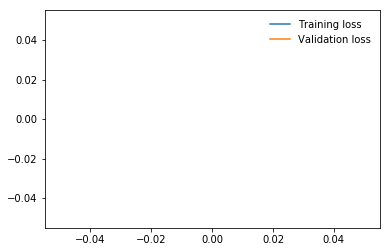

In [14]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

# loss 0.24 -> 2800
# loss 0.14 -> 3300

In [15]:
test_x = torch.from_numpy(test_x.values).float().to(device)

In [16]:

with torch.no_grad():
    model.eval()
    output = model.forward(test_x)
    

output.shape
output = output.cpu().numpy()
#output_col = pd.DataFrame(test, columns = columns)

output = y_scaler.inverse_transform(output)


In [17]:
submission = pd.read_csv('./dataset-0510/submit_test.csv')
submission['total_price'] = output
submission.to_csv('submission/DNN_result.csv', index=False)